Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

In [1]:
NAME = "Weijie Yuan"
COLLABORATORS = ""

---

# Project 2: NYC Taxi Rides
# Part 2: EDA, Visualization, Feature Engineering

In this part, we will conduct EDA on the NYC Taxi dataset that we cleaned and train/validation split in part 1. We will also guide you through the engineering of some features that hopefully will help our model to accurately understand the data.


# Imports

Let us start by loading the Python libraries and custom tools we will use in this part.  

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

sns.set(style="whitegrid", palette="muted")
%matplotlib inline

## Loading & Formatting data

The following code loads the data into a pandas DataFrame.

In [3]:
# Run this cell to load the data. 
data_file = Path("data/part1", "cleaned_data.hdf")
train_df = pd.read_hdf(data_file, "train")

In [4]:
train_df.head()

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
16434,8614300,2,2016-01-21 17:37:12,2016-01-21 18:37:56,2,10.89,-73.863403,40.769432,1,N,...,40.688210,1,41.5,1.0,0.5,6.00,0.0,0.3,49.30,3644.0
21929,7230200,2,2016-01-29 23:22:26,2016-01-29 23:31:23,2,1.00,-74.008087,40.739365,1,N,...,40.729271,1,7.0,0.5,0.5,1.66,0.0,0.3,9.96,537.0
3370,9830300,2,2016-01-05 18:50:16,2016-01-05 18:56:00,2,0.56,-73.972923,40.755650,1,N,...,40.758469,1,5.0,1.0,0.5,1.00,0.0,0.3,7.80,344.0
21975,7251500,2,2016-01-30 00:14:34,2016-01-30 00:47:13,1,6.65,-73.992027,40.718662,1,N,...,40.661118,1,25.5,0.5,0.5,2.68,0.0,0.3,29.48,1959.0
13758,6168000,1,2016-01-18 13:25:24,2016-01-18 13:38:51,1,2.10,-73.953125,40.784538,1,N,...,40.760792,2,11.5,0.0,0.5,0.00,0.0,0.3,12.30,807.0


## 1: Data Overview 

As a reminder, the raw taxi data contains the following columns:
- `recordID`: primary key of this database
- `VendorID`: a code indicating the provider associated with the trip record
- `passenger_count`: the number of passengers in the vehicle (driver entered value)
- `trip_distance`: trip distance
- `tpep_dropoff_datetime`: date and time when the meter was engaged
- `tpep_pickup_datetime`: date and time when the meter was disengaged
- `pickup_longitude`: the longitude where the meter was engaged
- `pickup_latitude`: the latitude where the meter was engaged
- `dropoff_longitude`: the longitude where the meter was disengaged
- `dropoff_latitude`: the latitude where the meter was disengaged
- `duration`: duration of the trip in seconds
- `payment_type`: the payment type
- `fare_amount`: the time-and-distance fare calculated by the meter
- `extra`: miscellaneous extras and surcharges
- `mta_tax`: MTA tax that is automatically triggered based on the metered rate in use	
- `tip_amount`: the	amount of credit card tips, cash tips are not included
- `tolls_amount`: amount paid for tolls
- `improvement_surcharge`: fixed fee
- `total_amount`: total amount paid by passengers, cash tips are not included

Let us take a closer look at the target `duration` variable. In the cell below, we plot its distribution using `sns.distplot`. This should give us an idea about whether we have some outliers in our data.

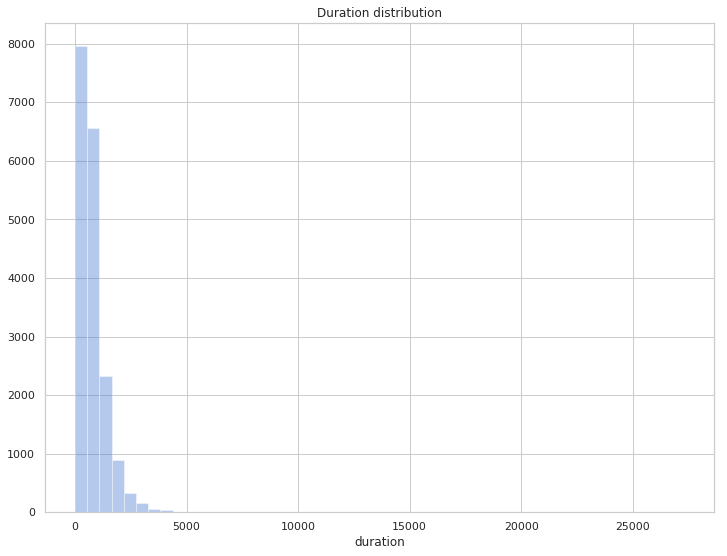

In [5]:
fig, ax = plt.subplots(figsize=(12, 9))

# Plot the distribution of duration using sns.distplot
# You can fill `ax=ax` to sns.distplot to plot in the ax object created above

sns.distplot(train_df['duration'], ax=ax, kde=False)

plt.title('Duration distribution');

As expected for a positive valued variable, we observe a skewed distribution. Note that we seem to have a handful of very long trips within our data. Use an appropriate data transformation to squeeze this highly-skewed distribution. Plot a `sns.distplot` of the transformed duration data for `train_df`.

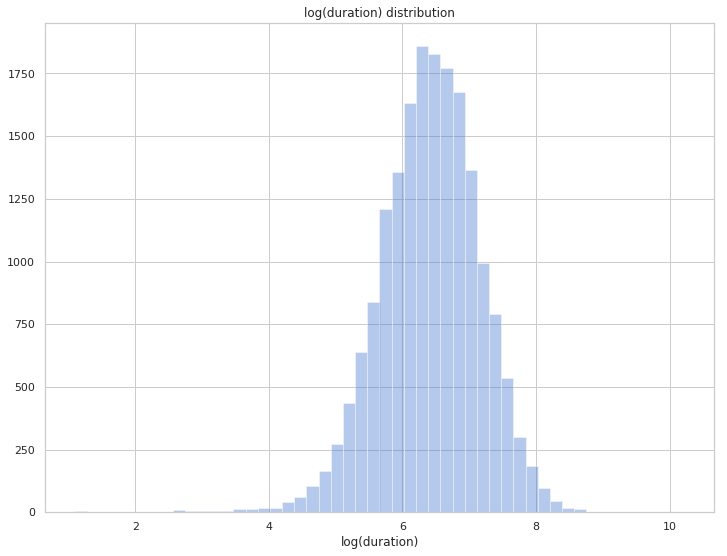

In [6]:
fig, ax = plt.subplots(figsize=(12, 9))

# Use a log transformation to squeeze the distribution
# You can add + 1 to all values before taking the log to handle possible 0 values for distribution

sns.distplot(np.log(train_df['duration'] + 1),
             ax=ax,
             axlabel='log(duration)',
             kde=False)

plt.title('log(duration) distribution');

After transforming our data, we should immediately observe that we are dealing with what seems to be log-normal distribution for the target variable `duration`. We can see the behavior of shorter rides better, whereas before they were lumped in a bar near 0. This is a nice result, since it can facilitate modeling later. 

**Note:** Keep in mind that we want to avoid peeking at our validation data because it may introduce bias. Therefore, we will be focusing on analyzing the training data for the remainder of this notebook.

## 2: Date Analysis

In order to understand the general pattern/trends of our taxi ride data, we will plot the number of taxi rides requested over time. Please run the following cell.

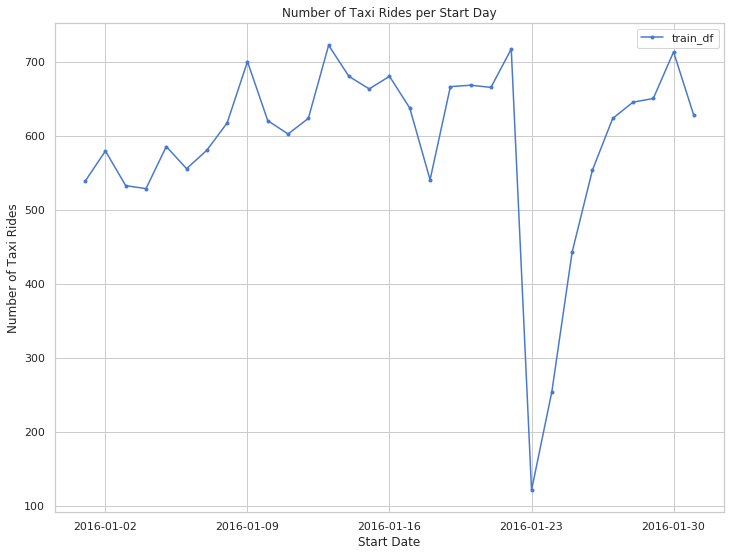

In [7]:
plt.figure(figsize=(12, 9))

# Make a temporary copy of our datasets
tmp_train = train_df.copy()
tmp_train['date'] = tmp_train['tpep_pickup_datetime'].dt.date
tmp_train = tmp_train.groupby('date').count()['pickup_longitude']

# Plot the temporal overlap
plt.plot(tmp_train, '.-', label='train_df')

plt.title('Number of Taxi Rides per Start Day')
plt.xlabel("Start Date")
plt.legend()
plt.ylabel('Number of Taxi Rides');

### Question 2a
Taking a closer look at the plot above, we notice a drastic drop in taxi rides towards the end of Janurary.
What is the date corresponding to the lowest number of taxi rides? Enter your answer as a string in the format MM-DD-YYYY.

In [8]:
lowest_rides_date = "01-23-2016"

# YOUR CODE HERE

print(lowest_rides_date)

01-23-2016


In [9]:
# Hidden test!

### Question 2b
What event could have caused this drop in taxi rides? Feel free to use Google.

In [10]:
q2b_answer = r"""

There is a crippling and historic blizzard called 'Snowzilla' happened at Jan, 2016 in 
the United States that produced up to 3 ft (91 cm) of snow in parts of the Mid-Atlantic 
and Northeast United States from January 22 to January 24, 2016. A travel ban was 
instituted for New York City and Newark, New Jersey for January 23–24, which led to a 
significant snowfall of number of taxi rides
"""

# YOUR CODE HERE

print(q2b_answer)



There is a crippling and historic blizzard called 'Snowzilla' happened at Jan, 2016 in 
the United States that produced up to 3 ft (91 cm) of snow in parts of the Mid-Atlantic 
and Northeast United States from January 22 to January 24, 2016. A travel ban was 
instituted for New York City and Newark, New Jersey for January 23–24, which led to a 
significant snowfall of number of taxi rides



## 3. Spatial/Locational Analysis

We are curious about the distribution of taxi pickup/dropoff coordinates. We also may be interested in observing whether this distribution changes as we condition of longer/shorter taxi rides. In the cells below, we will categorize our data into long and short rides based on duration. Then we will plot the latitude and longitude coordinates of rides conditioned on these categories.

First you may want to familiarize yourself with a [map of Manhattan](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

Here we split `train_df` into two data frames, one called `short_rides` and one called `long_rides`. `short_rides` should contain all rides less than or equal to 15 minutes and `long_rides` should contain rides more than 15 minutes. 

**Note:** We chose 15 minutes because the mean duration of a ride is roughly 700 seconds ~ 12 minutes. We then round up to the nearest nice multiple of 5. Note that you should adjust how you determine short/long rides and outliers when feature engineering.

In [11]:
short_rides = train_df[train_df["duration"] <= 900] # rides less than or equal to 15 mins
long_rides = train_df[train_df["duration"] > 900] # rides more than 15 minutes

In [12]:
assert len(short_rides) == 12830
assert len(long_rides) == 5524

Below we generate 4 scatter plots. The scatter plots are ordered as follows:

* ax1: plot the __start__ location of short duration rides
* ax2: plot the __start__ location of long duration rides
* ax3: plot the __end__ location of short duration rides
* ax4: plot the __end__ location of long duration rides

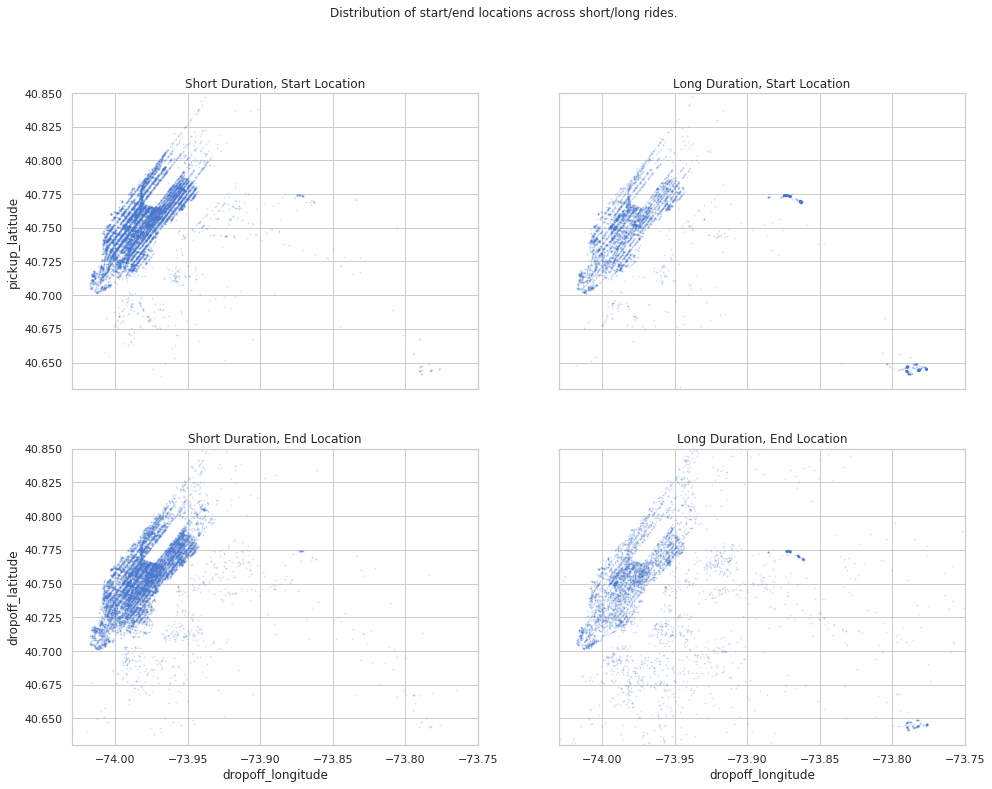

In [13]:
# Set random seed of reproducibility
random.seed(42)

# City boundaries
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Define figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows = 2, figsize=(16, 12), sharex=True, sharey=True)
alpha = 0.15 # make sure to include these as an argument
s = 1 # make sure to include this as an argument

short_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                     ax = ax1, alpha = alpha, s = s, title='Short Duration, Start Location')
long_rides.plot(kind = "scatter", x = "pickup_longitude", y = "pickup_latitude",
                    ax = ax2, alpha = alpha, s = s, title='Long Duration, Start Location')
short_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                     ax = ax3, alpha = alpha, s = s , title='Short Duration, End Location')
long_rides.plot(kind = "scatter", x = "dropoff_longitude", y = "dropoff_latitude",
                    ax = ax4, alpha = alpha, s = s, title='Long Duration, End Location')


fig.suptitle('Distribution of start/end locations across short/long rides.')


plt.ylim(city_lat_border)
plt.xlim(city_long_border);

### Question 3a

What do the plots above look like? 

In particular:
- Find what the following circled regions correspond to:
<img src="figs/nyc_locations.png" width="50%"></img>

**Hint: Here is a [page](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488) that may be useful.**

In [14]:
q3a_answer = r"""

The left circled region corresponds to Manhattan, New York, NY.
The right circled region corresponds to East Elmhurst, New York, where LaGuardia Airport is located.

"""

# YOUR CODE HERE

print(q3a_answer)



The left circled region corresponds to Manhattan, New York, NY.
The right circled region corresponds to East Elmhurst, New York, where LaGuardia Airport is located.




### Question 3b
In each scatter plot above, why are there no points contained within the small rectangular region (towards the top left between the blue points)? Could this be an error/mistake in our data?

In [15]:
q3b_answer = r"""

Compared with the Google map, this is not an error in our data. Because this small rectangular region
corresponds to Central Park, New York. It is not strange that there is no points there because taxies 
maybe not allowed to drive into Central Park, which is a natural attraction.

"""

# YOUR CODE HERE

print(q3b_answer)



Compared with the Google map, this is not an error in our data. Because this small rectangular region
corresponds to Central Park, New York. It is not strange that there is no points there because taxies 
maybe not allowed to drive into Central Park, which is a natural attraction.




### Question 3c
What observations/conclusions do you make based on the scatter plots above? In particular, how are trip duration and pickup/dropoff location related?

In [16]:
q3c_answer = r"""

The trips are highly concentrated in Manhattan and on the way to LaGuardia Airport.
For trips with short duration, the pickup location and dropoff location are highly concentrated only in 
Manhattan, mainly in lower Manhattan. By contrast, for trips with long duration, the pickup location and 
dropoff location are less concentrated in Manhattan. There are new concentration points, LaGuardia 
Airport and John F. Kennedy International Airport(bottom-right corner). It makes sense, because trips 
between Manhanttan and airports takes relatively longer time.

"""

# YOUR CODE HERE

print(q3c_answer)



The trips are highly concentrated in Manhattan and on the way to LaGuardia Airport.
For trips with short duration, the pickup location and dropoff location are highly concentrated only in 
Manhattan, mainly in lower Manhattan. By contrast, for trips with long duration, the pickup location and 
dropoff location are less concentrated in Manhattan. There are new concentration points, LaGuardia 
Airport and John F. Kennedy International Airport(bottom-right corner). It makes sense, because trips 
between Manhanttan and airports takes relatively longer time.




This confirms that the trips are localized in NYC, with a very strong concentration in Manhattan **and** on the way to LaGuardia Airport. This might give you ideas of relevant features for feature engineering.  

Another way to visualize ride coordinates is using a **heat map** (this also helps us avoid overplotting). The following plots count the number of trips for NYC neighborhoods and areas, plotting with the `geopandas` package and theses [shapefiles](https://geo.nyu.edu/catalog/nyu_2451_36743) (do not mind the values on the colorbar). If you are curious about how to create the figures below, feel free to check out [`geopandas`](http://geopandas.org/).

![neighborhoods](figs/chloro_NY_neighborhoods.png)
![neighborhoods](figs/chloro_NY_taxi_zones.png)

## 4: Temporal features
We can utilize the `start_timestamp` column to design a lot of interesting features.

We implement the following temporal (related to time) features using the `add_time_columns` function below.
- `month` derived from `start_timestamp`.
- `week_of_year` derived from `start_timestamp`.
- `day_of_month` derived from `start_timestamp`.
- `day_of_week` derived from `start_timestamp`.
- `hour` derived from `start_timestamp`.
- `week_hour` derived from `start_timestamp`.

**Note 1**: You can use the `dt` attribute of the `start_timestamp` column to convert the entry into a `DateTime` object.

**Note 2**: We set `df.is_copy = False` to explicitly write back to the original dataframe, `df`, that is being passed into the `add_time_columns` function. Otherwise `pandas` will complain.

In [17]:
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False 
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
 
    # No real need to return here, but we harmonize with remove_outliers for later pipelinezation
    return df

In [18]:
# Note that we are applying this transformation to train_df, short_rides and long_rides
train_df = add_time_columns(train_df)
short_rides = add_time_columns(short_rides)
long_rides = add_time_columns(long_rides)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [19]:
train_df[['month', 'week_of_year', 'day_of_month', 'day_of_week', 'hour', 'week_hour']].head()

,month,week_of_year,day_of_month,day_of_week,hour,week_hour
16434,1,3,21,3,17,89
21929,1,4,29,4,23,119
3370,1,1,5,1,18,42
21975,1,4,30,5,0,120
13758,1,3,18,0,13,13


Your `train_df.head()` should look like this, although the ordering of the data in `id` might be different:
![time_columns](figs/time_columns.png)

In [20]:
time_columns = ['month',
                'week_of_year',
                'day_of_month',
                'day_of_week',
                'hour',
                'week_hour']


# Check columns were created
assert all(column in train_df.columns for column in time_columns)

# Check type
assert train_df[time_columns].dtypes.nunique() == 1

assert train_df[time_columns].dtypes.nunique() == 1

### Visualizing Temporal Features

### Question 4a
Let us now use the features we created to plot some histograms and visualize patterns in our dataset. We will analyze the distribution of the number of taxi rides across months and days of the week. This can help us visualize and understand patterns and trends within our data.

This is a open ended question. Create 2 plots that visualize temporal information from our dataset. At least one of them must visualize the hour of each day. Aside from that you can use any column from `time_columns`. 

You can use the same column multiple times, but if the plots are redundant you will not receive full credit. This will be graded based on how informative each plot is and how "good" the visualization is (remember what good/bad visualizations look like for different kinds of data!).  

#### Visualization 1

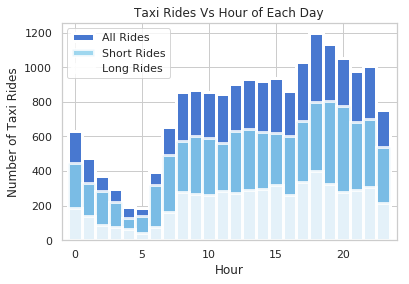

In [21]:
# Visualization 1
# YOUR CODE HERE
# ax = plt.hist(train_df['hour'],bins=24)
ax = sns.distplot(train_df['hour'],bins=np.linspace(-0.5,24.5,num=26),
                  kde=False, label = "All Rides",
                  hist_kws={"linewidth": 3, 
                            "alpha": 1, "color": "b"})
sns.distplot(short_rides['hour'] , bins=np.linspace(-0.5,24.5,num=26),
             color="skyblue", label="Short Rides",
             kde=False,
             hist_kws={"linewidth": 3, 
                       "alpha": 0.8})
sns.distplot(long_rides['hour'] , bins=np.linspace(-0.5,24.5,num=26),
             color="White", label="Long Rides",
             kde=False,
             hist_kws={"linewidth": 3, 
                       "alpha": 0.8})

plt.legend()

plt.xlim(-1,24)
plt.title('Taxi Rides Vs Hour of Each Day')
plt.xlabel('Hour')
plt.ylabel('Number of Taxi Rides')
plt.show()

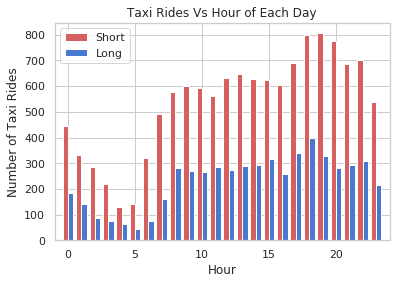

In [22]:
plt.hist([short_rides['hour'], long_rides['hour']], 
         bins=np.linspace(-0.5,24.5,num=26),
         color=['r','b'], 
         label = ['Short','Long'],
         alpha=1)
plt.xlim(-1,24)
plt.title('Taxi Rides Vs Hour of Each Day')
plt.xlabel('Hour')
plt.ylabel('Number of Taxi Rides')
plt.legend()
plt.show()

#### Visualization 2

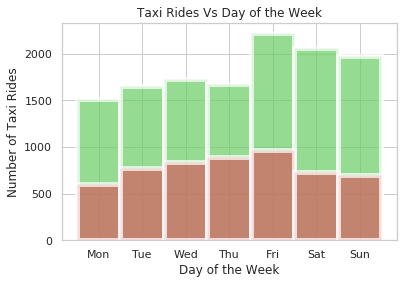

In [23]:
# Visualization 2
# YOUR CODE HERE
ax = sns.distplot(short_rides['day_of_week'],
                  bins=np.linspace(-0.5,6.5,num=8),
                  kde=False,
                  hist_kws={"linewidth": 5, 
                            "alpha": 0.7, "color": "g"})
ax = sns.distplot(long_rides['day_of_week'],
                  bins=np.linspace(-0.5,6.5,num=8),
                  kde=False,
                  hist_kws={"linewidth": 5, 
                            "alpha": 0.7, "color": "r"})

plt.title('Taxi Rides Vs Day of the Week')
plt.xlabel('Day of the Week')
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'))
plt.ylabel('Number of Taxi Rides')
plt.show()

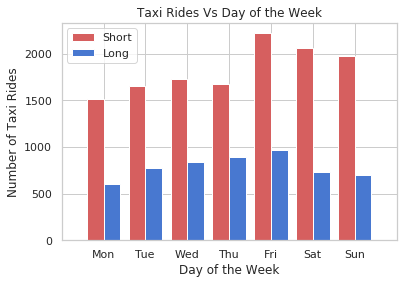

In [24]:
plt.hist([short_rides['day_of_week'], long_rides['day_of_week']], 
         bins=np.linspace(-0.5,24.5,num=26),
         color=['r','b'], 
         label = ['Short','Long'],
         alpha=1)
plt.xlim(-1,7)
plt.legend()
plt.title('Taxi Rides Vs Day of the Week')
plt.xlabel('Day of the Week')
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'))
plt.ylabel('Number of Taxi Rides')
plt.show()

### Question 4b
Briefly explain for each plot
1. What feature you're visualization
2. Why you chose this feature
3. Why you chose this visualization method

In [25]:
q4b_answer = r"""

In the first plot, I visualize the distribution of taxi rides with respect to the hour of each day.
The reason why I choose this feature is that it reveals the distribution of taxi rides across the hour 
of each day, which tells us the daily trend of fluctuation of taxi rides with comparison between long 
duration and short duration.
The reason why I choose the visualization method is that the number of taxt rides and the hours of 
each day are quantitative data and nominal data respectively. Besides, we need to compare taxi rides 
with short duration with those with long duration and we know that trips with short duration are more
than trips with long duration at all hours of a day. So I use multiple histogram in two ways to do 
this visualization.

In the second plot, I visualize the distribution of taxi rides with respect to the day of week.
The reason why I choose this feature is that it reveals the distribution of taxi rides across the days 
of each week, which tells us the weekly trend of fluctuation of taxi rides with comparison between long 
duration and short duration.
The reason why I choose the visualization method is that the number of taxt rides and the days of each
week are quantitative data and nominal data respectively. Besides, we need to compare taxi rides with short 
duration with those with long duration and we know that trips with short duration are more than trips with
long duration at all days of a week. So I use multiple histogram in two ways to do this visualization.
"""

# YOUR CODE HERE

print(q4b_answer)



In the first plot, I visualize the distribution of taxi rides with respect to the hour of each day.
The reason why I choose this feature is that it reveals the distribution of taxi rides across the hour 
of each day, which tells us the daily trend of fluctuation of taxi rides with comparison between long 
duration and short duration.
The reason why I choose the visualization method is that the number of taxt rides and the hours of 
each day are quantitative data and nominal data respectively. Besides, we need to compare taxi rides 
with short duration with those with long duration and we know that trips with short duration are more
than trips with long duration at all hours of a day. So I use multiple histogram in two ways to do 
this visualization.

In the second plot, I visualize the distribution of taxi rides with respect to the day of week.
The reason why I choose this feature is that it reveals the distribution of taxi rides across the days 
of each week, which tells us the week

### Question 4c

From the various plots above, what conclusions can you draw about the temporal aspects of our data? How does this relate to duration? 

In [26]:
q4c_answer = r"""

1. The daily trend and weekly trend of fluctuation of taxi rides with long duration and short duration
is somewhat similar. The only difference is that taxi rides with long duration is less than taxi rides
with short duration all the time.

2. Taxi rides reach the peak point at around 18:00 and 19:00 in a day, which maybe resulted from evening 
peak when people call a taxi to commute from work place to home. And the number of taxi rides begins to 
decrease from 22:00 to 5:00. It makes sense because less people are active at that time period.

3. Taxi rides reach the peak point at Friday in a week and maintain high level during the weekend. It 
makes sense because people are having fun going outside by taxi at the end of a week. The numbers of 
taxi rides from Monday to Thursday are somewhat similar and have only slight fluctuation.

"""

# YOUR CODE HERE

print(q4c_answer)



1. The daily trend and weekly trend of fluctuation of taxi rides with long duration and short duration
is somewhat similar. The only difference is that taxi rides with long duration is less than taxi rides
with short duration all the time.

2. Taxi rides reach the peak point at around 18:00 and 19:00 in a day, which maybe resulted from evening 
peak when people call a taxi to commute from work place to home. And the number of taxi rides begins to 
decrease from 22:00 to 5:00. It makes sense because less people are active at that time period.

3. Taxi rides reach the peak point at Friday in a week and maintain high level during the weekend. It 
makes sense because people are having fun going outside by taxi at the end of a week. The numbers of 
taxi rides from Monday to Thursday are somewhat similar and have only slight fluctuation.




### Question 4d

Previously, we have analyzed the temporal features `hour` and `day_of_week` independently, but these features may in fact have a relationship between each other. Determining the extent to their relationship may be useful in helping us create new features in our model. Create a violin plot that displays distribution of rides over each hour per day of the week.

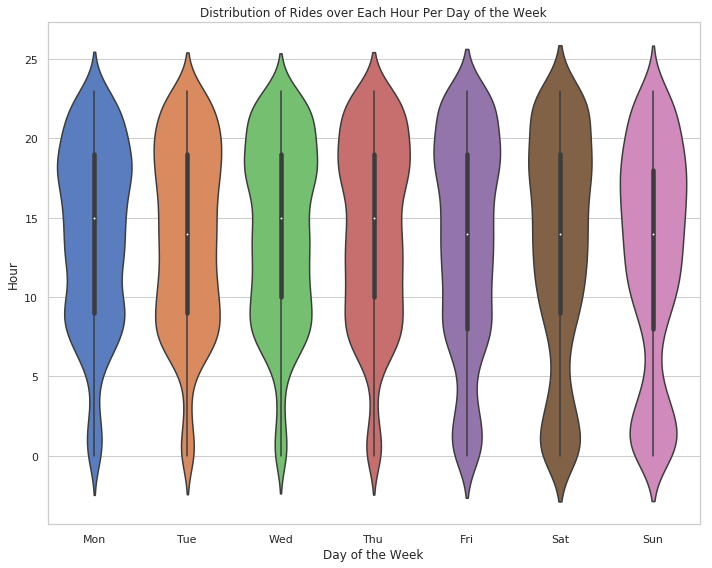

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


# YOUR CODE HERE
ax = sns.violinplot(x="day_of_week", y="hour", hue=None,
                    data=train_df)
plt.title('Distribution of Rides over Each Hour Per Day of the Week')
plt.xlabel('Day of the Week')
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'))
plt.ylabel('Hour')
plt.tight_layout();

### Question 4e
Do you notice anything interesting about your visualization? How would you explain this plot to a lay person? What are the features/patterns of interest?

In [28]:
q4e_answer = r"""

From Monday to Thursday, the distribution of rides over each hour per day of the week seems similiar. 
However, at Friday, Saturday and Sunday, the taxi rides become obiviously more biased to evening. i.e.
The number of taxi rides increases after midnight and the number of taxi rides decreases during 6:00-
12:00, in the morning and 20:00-23:00, in the evening.

Explaination: Violin plot shows the distribution of trips over each hour per day of the week, and 
it also shows the median and a long bar indicating the interquartile range.
These seven violin-like plots represent seven days in a week, from Monday to Sunday. And the vertical 
axes represent each hour in a day, from 0:00-24:00. The width of each plot represent the number of 
taxi rides at corresponding y-coordinate time in a certain day of a week. As a result, these violin 
plots reveal the distribution of rides over each hour per day of the week.

We are mostly interested in the width of each violin plots and different patterns of the distribution 
of rides over each hour per day of the week, which I described above. Also, we use different color to 
represent different days in a week, which is very helpful for a lay person to understand the plots.

"""

# YOUR CODE HERE

print(q4e_answer)



From Monday to Thursday, the distribution of rides over each hour per day of the week seems similiar. 
However, at Friday, Saturday and Sunday, the taxi rides become obiviously more biased to evening. i.e.
The number of taxi rides increases after midnight and the number of taxi rides decreases during 6:00-
12:00, in the morning and 20:00-23:00, in the evening.

Explaination: Violin plot shows the distribution of trips over each hour per day of the week, and 
it also shows the median and a long bar indicating the interquartile range.
These seven violin-like plots represent seven days in a week, from Monday to Sunday. And the vertical 
axes represent each hour in a day, from 0:00-24:00. The width of each plot represent the number of 
taxi rides at corresponding y-coordinate time in a certain day of a week. As a result, these violin 
plots reveal the distribution of rides over each hour per day of the week.

We are mostly interested in the width of each violin plots and different patter

## 5: Vendors

Recall that in Part 1, we found that there are only two unique vendors represented in the dataset. We may wonder if the vendor feature can be useful when trying to understand taxi ride duration.

### Question 5a
Visualize the VendorID feature. Create at least one plot that gives insight as to whether this feature would be useful or not in our model.

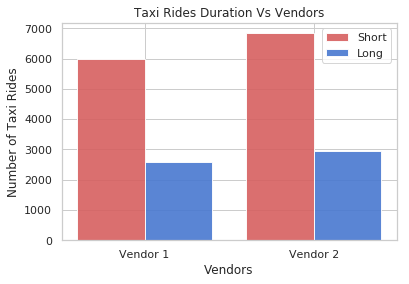

In [29]:
# Visualization

# YOUR CODE HERE
plt.hist([short_rides['VendorID'], long_rides['VendorID']], 
         bins=np.linspace(0.5,2.5,num=3),
         color=['r','b'], 
         label = ['Short','Long'],
         alpha=0.9)
plt.legend()
plt.title('Taxi Rides Duration Vs Vendors')
plt.xlabel('Vendors')
plt.xticks(np.arange(1,3), ('Vendor 1','Vendor 2'))
plt.ylabel('Number of Taxi Rides')
plt.show()

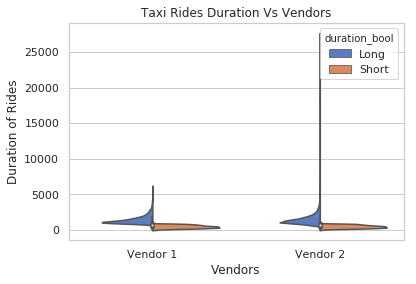

In [30]:
# Alternatively, we can use violin plots
tmp_train_violin = train_df.copy()
tmp_train_violin['duration_bool'] = train_df["duration"] <= 900
tmp_train_violin['duration_bool'] = ['Short' if e == True else 'Long' for e in 
                                     tmp_train_violin['duration_bool']]
ax = sns.violinplot(x="VendorID", y="duration", hue="duration_bool",
                    data=tmp_train_violin, palette="muted", split=True)
plt.title('Taxi Rides Duration Vs Vendors')
plt.xlabel('Vendors')
plt.xticks(np.arange(2), ('Vendor 1','Vendor 2'))
plt.ylabel('Duration of Rides')
plt.show()

### Question 5b
Justify why you chose this visualization method and how it helps determine whether `vendor_id` is useful in our model or not.

In [31]:
q5b_answer = r"""

The reason why I choose the visualization method is that the number of taxt rides and the VendorID are
quantitative data and nominal data respectively. Besides, we need to compare numbers of taxi rides with 
short duration with those with long duration. So I use multiple histogram and violin plots to do this 
visualization.

If the distributions of trips with long duration and short duration are largely different between two 
vendors, in this case, the corresponding areas of histogram and violin plots are largely different 
between two vendors, then we can conclude that 'vendor_id' is useful in our model. Otherwise, not.

"""

# YOUR CODE HERE

print(q5b_answer)



The reason why I choose the visualization method is that the number of taxt rides and the VendorID are
quantitative data and nominal data respectively. Besides, we need to compare numbers of taxi rides with 
short duration with those with long duration. So I use multiple histogram and violin plots to do this 
visualization.

If the distributions of trips with long duration and short duration are largely different between two 
vendors, in this case, the corresponding areas of histogram and violin plots are largely different 
between two vendors, then we can conclude that 'vendor_id' is useful in our model. Otherwise, not.




### Question 5c
From the plot above, do you think vendor_id will help us understand duration? Why or why not?

In [32]:
train_df[train_df['duration']>10000]

,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,tolls_amount,improvement_surcharge,total_amount,duration,month,week_of_year,day_of_month,day_of_week,hour,week_hour
1191,410100,2,2016-01-02 18:53:07,2016-01-03,1,18.18,-73.776894,40.645096,2,N,...,0.00,0.3,52.80,18413.0,1,53,2,5,18,138
13198,5646700,2,2016-01-17 16:56:09,2016-01-18,5,8.29,-73.873070,40.774101,1,N,...,5.54,0.3,36.62,25431.0,1,2,17,6,16,160
1836,844900,2,2016-01-03 16:25:03,2016-01-04,1,1.69,-73.974220,40.764004,1,N,...,0.00,0.3,9.80,27297.0,1,53,3,6,16,160


In [33]:
q5c_answer = r"""

As the dataframe shows above, vendor 2 has 3 trips with durations bigger than 10000s, but the 
trip_distance does not match that long duration. So, we may consider these three records are not 
trustful.

As a result, ignoring these three records, I think vendor_id will not help up understand duration 
because the corresponding areas of histogram and violin plots with short duration and long duration 
both are similar between two vendors. Therefore, vendor feature maybe not very useful and informative 
when trying to understand taxi ride duration.

"""

# YOUR CODE HERE

print(q5c_answer)



As the dataframe shows above, vendor 2 has 3 trips with durations bigger than 10000s, but the 
trip_distance does not match that long duration. So, we may consider these three records are not 
trustful.

As a result, ignoring these three records, I think vendor_id will not help up understand duration 
because the corresponding areas of histogram and violin plots with short duration and long duration 
both are similar between two vendors. Therefore, vendor feature maybe not very useful and informative 
when trying to understand taxi ride duration.




## 6: Distance features

We can also use the coordinates information to compute distance features.  This will allow us to compute speed related features.  
We will compute the [haversine](https://en.wikipedia.org/wiki/Haversine_formula) distance, the [manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distance and the [bearing](http://www.mathsteacher.com.au/year7/ch08_angles/07_bear/bearing.htm) angle.

In [34]:
# These functions are implemented for you
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    
    The haversine formula determines the great-circle distance between two points 
    on a sphere given their longitudes and latitudes. Important in navigation, it 
    is a special case of a more general formula in spherical trigonometry, 
    the law of haversines, that relates the sides and angles of spherical triangles.
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Computes Manhattan distance
    
    The name alludes to the grid layout of most streets on the island of Manhattan, 
    which causes the shortest path a car could take between two intersections in the borough 
    to have length equal to the intersections' distance in taxicab geometry.
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [35]:
def add_distance_columns(df):
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    
    return df

In [36]:
train_df = add_distance_columns(train_df)
short_rides = add_distance_columns(short_rides)
long_rides = add_distance_columns(long_rides)

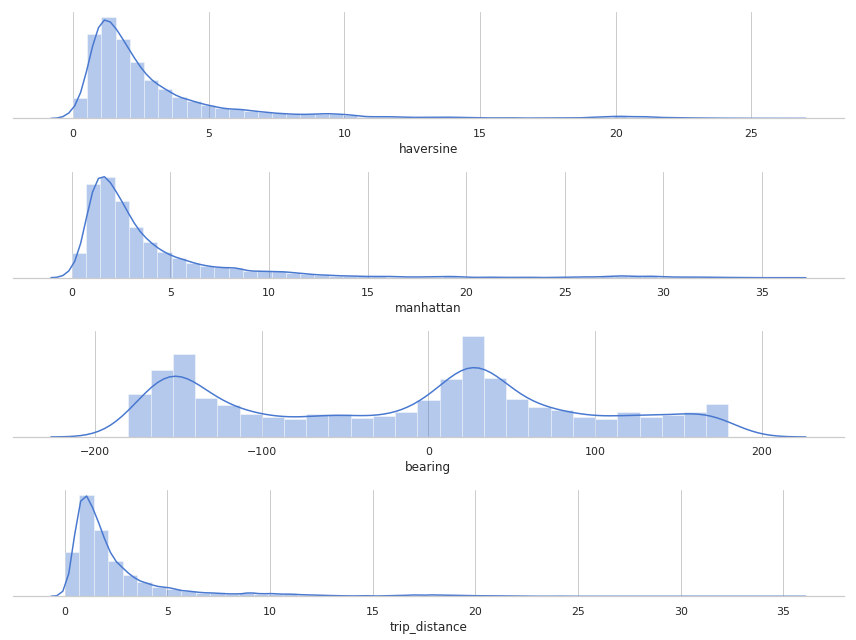

In [37]:
fig, axes = plt.subplots(4, 1, figsize=(12, 9))
sns.distplot(train_df['haversine'], ax=axes[0], axlabel='haversine');
sns.distplot(train_df['manhattan'], ax=axes[1], axlabel='manhattan');
sns.distplot(train_df['bearing'], ax=axes[2], axlabel='bearing');
sns.distplot(train_df['trip_distance'], ax=axes[3], axlabel='trip_distance');

sns.despine(left=True);
plt.setp(axes, yticks=[]);
plt.tight_layout();


### Question 6a

The `bearing` direction is angle, the initial direction of the trip.  
The bearing direction has two prominent peaks around 30 and -150 degrees.  
**Can you relate these peaks to the orientation of Manhattan? What do you notice about these angles?**

**Hint:** This [wikipedia article](https://en.wikipedia.org/wiki/Commissioners%27_Plan_of_1811) has the answer, although it may take some digging. Alternatively, try to look at a map of Manhattan.

In [38]:
q6a_answer = r"""

The orientation of the streets was to be true north–south and east–west, not shifted, as Manhattan 
Island is, 29 degrees east of true north. As a result, the bearing of taxi rides along most of 
streets from lower Manhattan to upper Manhattan is 30 degrees. At the other hand, the bearing of 
taxi rides along most of streets from upper Manhattan to lower Manhattan is -150 degrees.

"""

# YOUR CODE HERE

print(q6a_answer)



The orientation of the streets was to be true north–south and east–west, not shifted, as Manhattan 
Island is, 29 degrees east of true north. As a result, the bearing of taxi rides along most of 
streets from lower Manhattan to upper Manhattan is 30 degrees. At the other hand, the bearing of 
taxi rides along most of streets from upper Manhattan to lower Manhattan is -150 degrees.




### Question 6b

For haversine and manhattan distances, it is probably more helpful to look at the log distribution. We are also curious about whether these distance features can help us understand duration. Create at least one plot that compares haversine and manhattan distances and gives insight as to whether this would be a useful feature in our model.

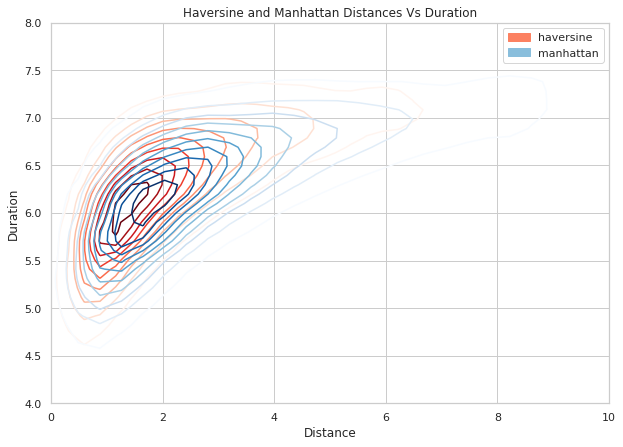

In [39]:
# Visualization
# YOUR CODE HERE
import matplotlib.patches as mpatches
plt.figure(figsize=(10,7))
ax1 = sns.kdeplot(train_df['haversine'],np.log(train_df['duration']+1),cmap="Reds")
ax2 = sns.kdeplot(train_df['manhattan'],np.log(train_df['duration']+1),cmap="Blues")

r = sns.color_palette("Reds")[2]
b = sns.color_palette("Blues")[2]

red_patch = mpatches.Patch(color=r, label='haversine')
blue_patch = mpatches.Patch(color=b, label='manhattan')

plt.xlim(0,10)
plt.ylim(4,8)
plt.title('Haversine and Manhattan Distances Vs Duration')
plt.xlabel('Distance')
plt.ylabel('Duration')

plt.legend(handles=[red_patch,blue_patch])
plt.show()

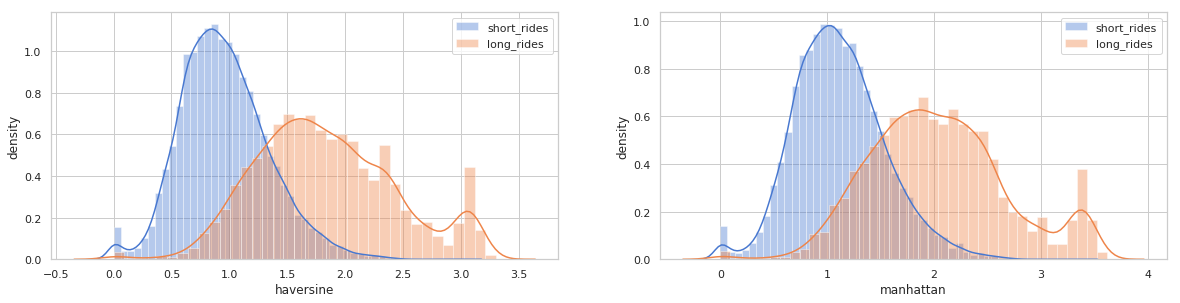

In [40]:
plt.figure(figsize=(20,10))
ax1=plt.subplot(2, 2, 1)
sns.distplot(np.log(short_rides['haversine']+1), label='short_rides')
sns.distplot(np.log(long_rides['haversine']+1), label='long_rides')
plt.legend()
plt.xlabel("haversine")
plt.ylabel("density");

ax2=plt.subplot(2, 2, 2)
sns.distplot(np.log(short_rides['manhattan']+1), label='short_rides')
sns.distplot(np.log(long_rides['manhattan']+1), label='long_rides')
plt.legend()
plt.xlabel("manhattan")
plt.ylabel("density");

### Question 6c
Justify why you chose this visualization method and how it helps inform you about using manhattan/haversine distance as a feature for predicting trip duration.

In [41]:
q6c_answer = r"""

The reason why I choose the visualization method is that the duration of taxt rides and the distance are
both quantitative data. Besides, we need to compare haversine distance and manhattan distance. So I use 
contour plots and subplots to do this visualization.

First, it informs me the relationship between these two distances and the duration of taxi rides. If they
are highly correlated, we may choose the corresponding feature. Secondly, the contour plot compares these 
two distances by representing them in the same plot and avoids overplotting at the same time. Finally, the 
relationship between manhattan and haversine distance is almost linear, so their distribution shape should
be very similar.

"""

# YOUR CODE HERE

print(q6c_answer)



The reason why I choose the visualization method is that the duration of taxt rides and the distance are
both quantitative data. Besides, we need to compare haversine distance and manhattan distance. So I use 
contour plots and subplots to do this visualization.

First, it informs me the relationship between these two distances and the duration of taxi rides. If they
are highly correlated, we may choose the corresponding feature. Secondly, the contour plot compares these 
two distances by representing them in the same plot and avoids overplotting at the same time. Finally, the 
relationship between manhattan and haversine distance is almost linear, so their distribution shape should
be very similar.




### Question 6d
Fill in the code below to plot a scatter plot of manhattan distance vs duration.

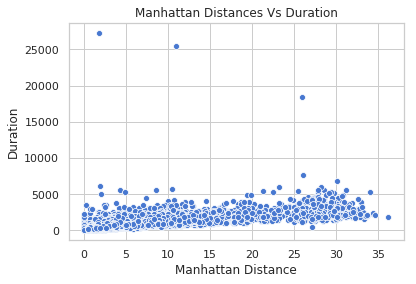

In [42]:
# YOUR CODE HERE
ax1 = sns.scatterplot(x="manhattan", y="duration", data=train_df)

plt.title('Manhattan Distances Vs Duration')
plt.xlabel('Manhattan Distance')
plt.ylabel('Duration')

plt.show()

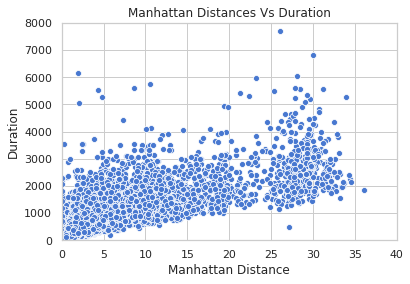

In [43]:
# We should remove some outliers to make the scatter plot more readable
ax2 = sns.scatterplot(x="manhattan", y="duration", data=train_df)

plt.title('Manhattan Distances Vs Duration')
plt.xlabel('Manhattan Distance')
plt.ylabel('Duration')
plt.xlim(0,40)
plt.ylim(0,8000)

plt.show()

### Question 6e

According to the plot above, there are a few outliers in both duration and manhattan distance. **Which type of outliers is most likely to be a mistake in our data?**

In [44]:
q6e_answer = r"""

An outlier with an extremely large duration but a small manhanttan distance might be plausible - since 
there are other factors at play (e.g. traffic jam) that might affect duration. This kind of outliers are
rare but might be plausible.
However, if we have a data point with extremely small duration but large manhattan distance, that's an 
outlier that we can most likely attribute to human error. Because it is safe to assume that taxi rides have
a upper limit of driving speed.

"""

# YOUR CODE HERE

print(q6e_answer)



An outlier with an extremely large duration but a small manhanttan distance might be plausible - since 
there are other factors at play (e.g. traffic jam) that might affect duration. This kind of outliers are
rare but might be plausible.
However, if we have a data point with extremely small duration but large manhattan distance, that's an 
outlier that we can most likely attribute to human error. Because it is safe to assume that taxi rides have
a upper limit of driving speed.




## 7: Advanced features
You do not need to incorporate these features into your model, although it may help lower your error. You are required to read through this portion and respond to the questions. All of the code is provided, please skim through it and try to understand what each cell is doing.

### Clustering
[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) is the task of grouping objects such that members within each group are more similar to each other than members of other groups. Clustering is a powerful tool used in many fields, including machine learning, pattern recognition, image analysis, information retrieval, bioinformatics, data compression, and computer graphics. Recall cluster sampling, which we learned earlier in the semester. We will use a simple clustering method (clustering by spatial locality) to reveal some more advanced features.

### Speed features

For `train_df`, we have the `duration` and now some distance information.  
This is enough for us to compute average speed and try to better understand our data.   

For `test_df`, we cannot use `duration` as a feature because it is what we are trying to predict. One clever way to include speed information for modeling would be as follows:

1. Cluster the observations in `train_df` by rounding the latitude and longitudes.
2. Compute the average speed per pickup cluster and dropoff cluster.
3. Match each observation in `test_df` to its pickup cluster and dropoff cluster based off the latitude and longitude, thus assigning the average speed for the pickup and dropoff cluster.
4. We have added speed information as features for `test_df`.

Therefore, we have propagated information computed in the `train_df` into the `test_df` via clustering. This is not something we will do in this notebook, although you can try it for yourself!

Other information that could be added based on clustering (both pickup cluster and dropoff cluster):
- Average of `avg_speed_h` per cluster.
- Average of `duration` per cluster.
- Average of `avg_speed_h` per cluster and hour.
- Average of `duration` per cluster and hour.
- In-cluster flow of trips for 60 min period.
- Out-cluster flow of trips for 60 min period.

In [45]:
# Calculate average manhattan speed
train_df['avg_speed_m'] = 1000 * train_df['manhattan'] / train_df['duration']
train_df['avg_speed_m'] = train_df['avg_speed_m'][train_df['avg_speed_m'] < 100]
train_df['avg_speed_m'].fillna(train_df['avg_speed_m'].median(), inplace=True)

In [46]:
train_df['avg_speed_m'].describe()

count    18354.000000
mean         5.210825
std          2.883174
min          0.000000
25%          3.287328
50%          4.617264
75%          6.413992
max         59.225577
Name: avg_speed_m, dtype: float64

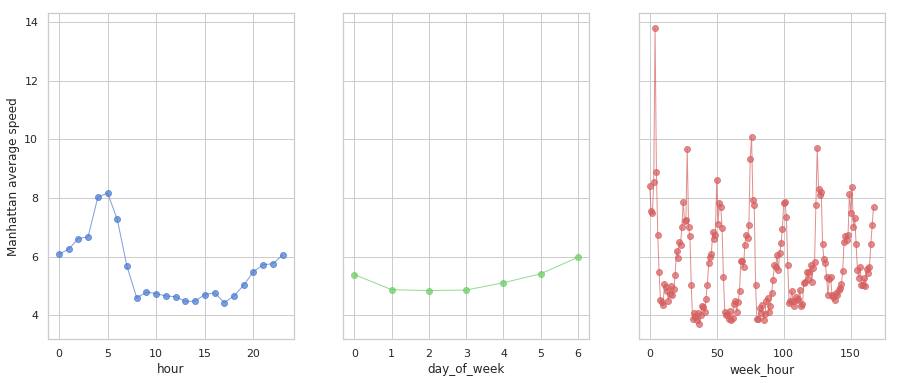

In [47]:
# Visualize average manhattan speed by hour, day of week and week hour
fig, axes = plt.subplots(ncols=3, figsize=(15, 6), sharey=True)

axes[0].plot(train_df.groupby('hour').mean()['avg_speed_m'], 'bo-', lw=1, alpha=0.7)
axes[1].plot(train_df.groupby('day_of_week').mean()['avg_speed_m'], 'go-', lw=1, alpha=0.7)
axes[2].plot(train_df.groupby('week_hour').mean()['avg_speed_m'], 'ro-', lw=1, alpha=0.7)

axes[0].set_xlabel('hour')
axes[1].set_xlabel('day_of_week')
axes[2].set_xlabel('week_hour')
axes[0].set_ylabel('Manhattan average speed');

### Question 7a
Based off of these visualizations, provide 2-3 insights on the average speed.

In [48]:
q7a_answer = r"""

1. The average speed reach its peak point around 5:00 in a day when the streets are more likely to be 
empty. Besides, the average speed begins to decrease during 5:00-8:00 and maintain low level during 
8:00-17:00 because of the heavy traffic during the daytime. It begins to increase after 17:00, with 
less and less cars on the streets.

2. The averge speed is more likely to be high during the weekend and Monday. At weekends, it makes sense
because there are lighter traffic on the steets.

3. There is a extremly high peak point and high fluctuation at the beginning of week_hour. It happens 
after midnight between Sunday and Monday. And the average speed appears to be daily periodic in a week.

"""

# YOUR CODE HERE

print(q7a_answer)



1. The average speed reach its peak point around 5:00 in a day when the streets are more likely to be 
empty. Besides, the average speed begins to decrease during 5:00-8:00 and maintain low level during 
8:00-17:00 because of the heavy traffic during the daytime. It begins to increase after 17:00, with 
less and less cars on the streets.

2. The averge speed is more likely to be high during the weekend and Monday. At weekends, it makes sense
because there are lighter traffic on the steets.

3. There is a extremly high peak point and high fluctuation at the beginning of week_hour. It happens 
after midnight between Sunday and Monday. And the average speed appears to be daily periodic in a week.




We are now going to visualize the average speed per region. Here we define regions as a very basic classical clustering based on rounding of spatial coordinates.

In [49]:
# Round / bin the latitude and longitudes
train_df['start_lat_bin'] = np.round(train_df['pickup_latitude'], 3)
train_df['start_lng_bin'] = np.round(train_df['pickup_longitude'], 3)

# Average speed for regions
gby_cols = ['start_lat_bin', 'start_lng_bin']

coord_stats = (train_df.groupby(gby_cols)
               .agg({'avg_speed_m': 'mean', 'manhattan': 'count'})
               .reset_index())

coord_stats = coord_stats[coord_stats['manhattan'] > 10]

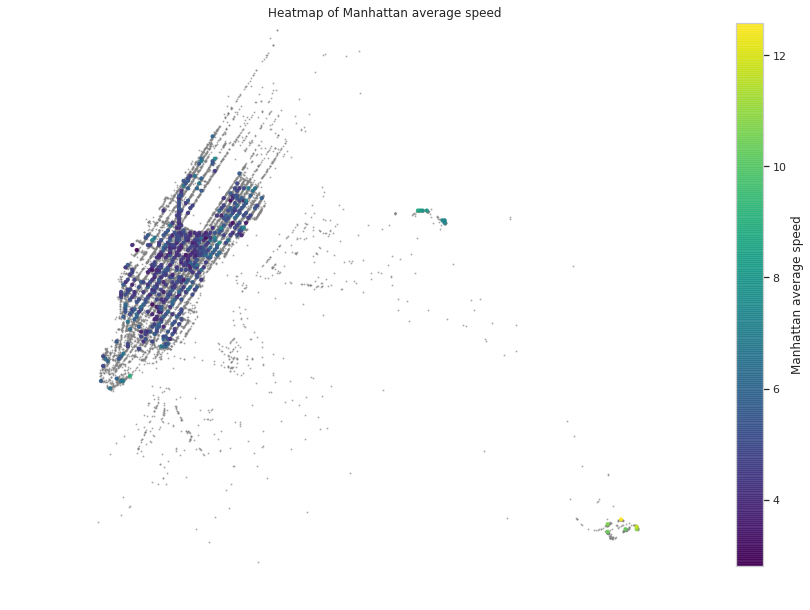

In [50]:
# Visualize the average speed per region
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))

scatter_trips = ax.scatter(train_df['pickup_longitude'].values,
                           train_df['pickup_latitude'].values,
                           color='grey', s=1, alpha=0.5)

scatter_cmap = ax.scatter(coord_stats['start_lng_bin'].values,
                          coord_stats['start_lat_bin'].values,
                          c=coord_stats['avg_speed_m'].values,
                          cmap='viridis', s=10, alpha=0.9)

cbar = fig.colorbar(scatter_cmap)
cbar.set_label("Manhattan average speed")
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Heatmap of Manhattan average speed')
plt.axis('off');

### Question 7b
In 2-3 sentences, describe how we can use the clustering visualization above to gain insight on the speed. Do you think spatial clustering would be useful in reducing the error of our model?

In [51]:
q7b_answer = r"""

From the above clusting visualization, we can gain insight that the speed is more likely to be low in
City Manhattan and to be high when the pickup site of taxi rides is near LaGuardia Airport and other 
remote place like data points at right-bottom of the heatmap above.

I think spatial clustering would be useful in reducing the erro of our model. Because at different spatial
coordinates of Manhattan, the traffic condition would be different as well, which definitely has effect 
on speed of taxi rides. Speed is obviously a significant factor to the duration of taxi rides, which is our
target variable.

"""

# YOUR CODE HERE

print(q7b_answer)



From the above clusting visualization, we can gain insight that the speed is more likely to be low in
City Manhattan and to be high when the pickup site of taxi rides is near LaGuardia Airport and other 
remote place like data points at right-bottom of the heatmap above.

I think spatial clustering would be useful in reducing the erro of our model. Because at different spatial
coordinates of Manhattan, the traffic condition would be different as well, which definitely has effect 
on speed of taxi rides. Speed is obviously a significant factor to the duration of taxi rides, which is our
target variable.




## Part 2 Exports
We are not requiring you to export anything from this notebook, but you may find it useful to do so. There is a space below for you to export anything you wish.

In [52]:
Path("data/part2").mkdir(parents=True, exist_ok=True)
data_file = Path("data/part2", "data_part2.hdf") # Path of hdf file
...

Ellipsis

## Part 2 Conclusions 

We now have a good understanding of the taxi data we are working with.
Visualizing large amounts of data can be a difficult task. One helpful tool is [datashader](https://github.com/bokeh/datashader), a data rasterization pipeline for automating the process of creating meaningful representations of large amounts of data. Using the [geopandas](http://geopandas.org/) package also makes working with geospatial data easier. We encourage you to explore these tools if you are interested in learning more about visualization!

Within our taxi data set, we have explored different features and their relationship with ride duration. Now, we are ready to incorporate more data in order to add to our set of features.

**Please proceed to part 3 where we will be engineering more features and building our models using a processing pipeline.**

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**